# Basic Setup

## Imports

In [52]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [66]:
!pip freeze > requirements.txt

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [67]:
train_dir = '/kaggle/input/soil-classification/soil_classification-2025/train'
test_dir = '/kaggle/input/soil-classification/soil_classification-2025/test'

train_csv_path = '/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv'
test_csv_path = '/kaggle/input/soil-classification/soil_classification-2025/test_ids.csv'

batch_size = 32
num_epochs = 20
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 4

train_csv['soil_type'].value_counts()

soil_type
Alluvial soil    528
Red soil         264
Black Soil       231
Clay soil        199
Name: count, dtype: int64

## Datasets Boilerplate

In [54]:
class SoilDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, train=True):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        self.class_to_idx = {'Alluvial soil': 0, 'Red soil': 1, 'Black Soil': 2, 'Clay soil': 3}
        
        if self.train:
            self.data['label'] = self.data['soil_type'].map(self.class_to_idx)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['image_id']
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.train:
            label = self.data.iloc[idx]['label']
            return image, label
        else:
            return image, img_name

## Transformers

In [55]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


## Training/Validation Split

In [56]:
train_dataset = SoilDataset(train_csv_path, train_dir, transform=train_transform, train=True)

val_split = 0.15
val_size = int(len(train_dataset) * val_split)
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

val_dataset.dataset.transform = val_transform  # val uses val_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Used **focal loss** to help with class imbalance 

In [57]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')
        
    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


# Building and Training Model

In [58]:
model = models.resnet50(pretrained=True)

# Unfreeze last two layers (layer4 and fc)
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Replace final fully connected layer with dropout
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, num_classes)
)

model = model.to(device)

criterion = FocalLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


- Set up early stopping with patience level **4**
- Set up model checkpoints (automatically saves best model)

In [63]:
best_val_acc = 0
patience = 4
counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total
    
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), "best_resnet50_soil.pth")
        print("Saved Best Model!")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch [1/20] Train Loss: 0.0074 Train Acc: 0.9904 Val Loss: 0.0340 Val Acc: 0.9781
Saved Best Model!
Epoch [2/20] Train Loss: 0.0112 Train Acc: 0.9971 Val Loss: 0.0091 Val Acc: 0.9945
Saved Best Model!
Epoch [3/20] Train Loss: 0.0058 Train Acc: 0.9952 Val Loss: 0.0066 Val Acc: 0.9945
Epoch [4/20] Train Loss: 0.0052 Train Acc: 0.9933 Val Loss: 0.0118 Val Acc: 0.9891
Epoch [5/20] Train Loss: 0.0019 Train Acc: 0.9990 Val Loss: 0.0057 Val Acc: 0.9891
Epoch [6/20] Train Loss: 0.0024 Train Acc: 0.9981 Val Loss: 0.0160 Val Acc: 0.9891
Early stopping triggered.


## Model Metrics

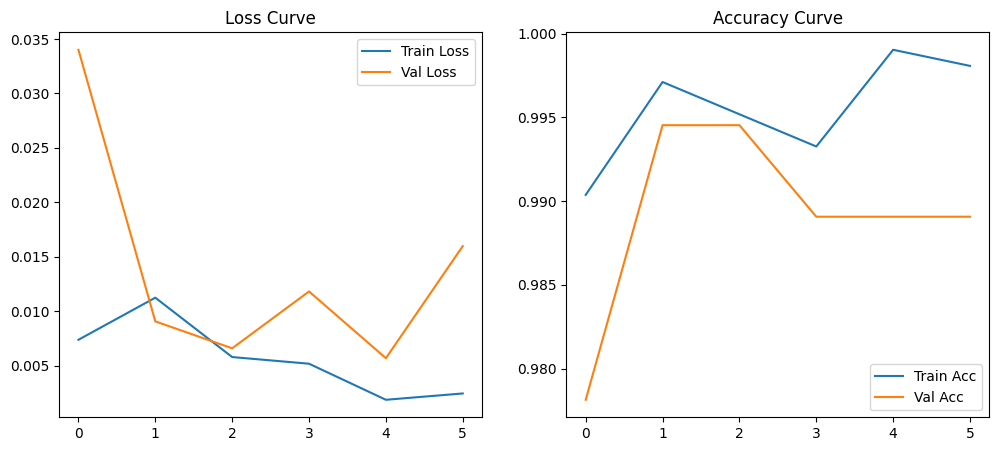

In [64]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

# Prediction

✅ Predictions saved to submission.csv
🔍 Accuracy against sample submission: 16.67%


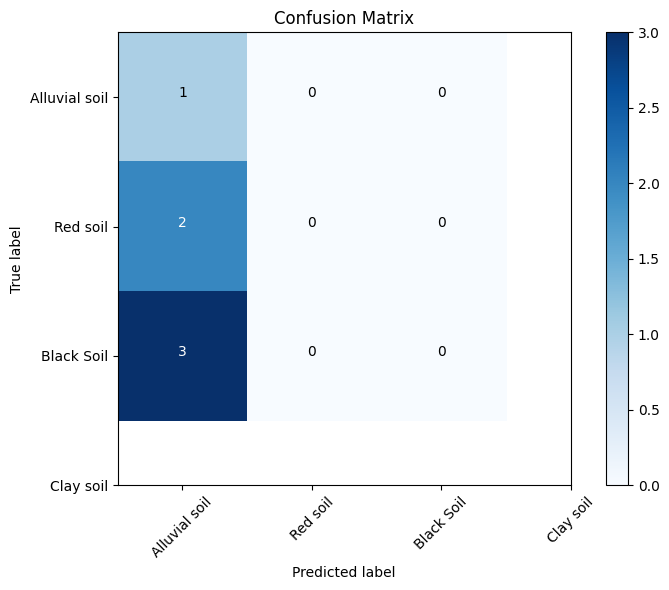

In [65]:
model.load_state_dict(torch.load("best_resnet50_soil.pth"))
model.eval()

test_dataset = SoilDataset(test_csv_path, test_dir, transform=val_transform, train=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

soil_type_map = {0: 'Alluvial soil', 1: 'Red soil', 2: 'Black Soil', 3: 'Clay soil'}

predictions = []
image_ids = []

with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        preds = preds.cpu().numpy()
        predictions.extend(preds)
        image_ids.extend(img_names)

pred_labels = [soil_type_map[p] for p in predictions]

submission_df = pd.DataFrame({'image_id': image_ids, 'soil_type': pred_labels})
submission_df.to_csv("submission.csv", index=False)
print("Predictions saved to submission.csv")

sample_submission_path = "/kaggle/input/soil-classification/soil_classification-2025/sample_submission.csv"
if os.path.exists(sample_submission_path):
    sample_sub = pd.read_csv(sample_submission_path)
    merged = pd.merge(submission_df, sample_sub, on='image_id', suffixes=('_pred', '_true'))
    correct = (merged['soil_type_pred'] == merged['soil_type_true']).sum()
    total = len(merged)
    acc = correct / total * 100
    print(f"🔍 Accuracy against sample submission: {acc:.2f}%")
    
    # Confusion Matrix
    y_true = merged['soil_type_true'].map({v:k for k,v in soil_type_map.items()}).values
    y_pred = merged['soil_type_pred'].map({v:k for k,v in soil_type_map.items()}).values
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, soil_type_map.values(), rotation=45)
    plt.yticks(tick_marks, soil_type_map.values())
    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
else:
    print("No sample_submission.csv found for evaluation.")



In [70]:
from sklearn.metrics import classification_report

# Ensure consistent mapping between string labels and integer indices
soil_type_map = {0: 'Alluvial soil', 1: 'Red soil', 2: 'Black Soil', 3: 'Clay soil'}
reverse_soil_type_map = {v: k for k, v in soil_type_map.items()}

# True and predicted labels as integer indices
y_true = merged['soil_type_true'].map(reverse_soil_type_map).values
y_pred = merged['soil_type_pred'].map(reverse_soil_type_map).values

# Specify labels explicitly (even if some classes have zero counts)
labels = [0, 1, 2, 3]

# Compute and print class-wise F1 scores
report = classification_report(y_true, y_pred, labels=labels, target_names=[soil_type_map[l] for l in labels], zero_division=0, output_dict=True)

# Print F1-scores for each class
print("🔍 Class-wise F1-scores:")
for label in labels:
    print(f"{soil_type_map[label]}: F1-score = {report[soil_type_map[label]]['f1-score']:.4f}")


🔍 Class-wise F1-scores:
Alluvial soil: F1-score = 0.2857
Red soil: F1-score = 0.0000
Black Soil: F1-score = 0.0000
Clay soil: F1-score = 0.0000


In [72]:
from sklearn.metrics import f1_score

# Collect predictions and true labels from val_loader
model.eval()
val_true = []
val_preds = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        val_true.extend(labels.cpu().numpy())
        val_preds.extend(preds.cpu().numpy())

# Calculate class-wise F1 scores
f1_scores = f1_score(val_true, val_preds, average=None, labels=[0,1,2,3])

soil_types = ['Alluvial soil', 'Red soil', 'Black Soil', 'Clay soil']
print("Validation Class-wise F1 Scores:")
for soil, score in zip(soil_types, f1_scores):
    print(f"{soil}: F1-score = {score:.4f}")


Validation Class-wise F1 Scores:
Alluvial soil: F1-score = 0.9943
Red soil: F1-score = 1.0000
Black Soil: F1-score = 1.0000
Clay soil: F1-score = 0.9836
